# Facial Keypoint Dataset

**NOTE: Before running this notebook, please download the the data zips from from the Kaggle Competition [Facial Keypoint Detections](https://www.kaggle.com/competitions/facial-keypoints-detection/overview) and place them in a folder called `data` in the current directory. The specific data files are `training.zip` and `test.zip`**
  
This project will be all about defining and training a convolutional neural network to perform facial keypoint detection, and using computer vision techniques to transform images of faces. In each training and test image, there is a single face and **68 keypoints, with coordinates (x, y), for that face**.  These keypoints mark important areas of the face: the eyes, corners of the mouth, the nose, etc. These keypoints are relevant for a variety of tasks, such as face filters, emotion recognition, pose recognition, and so on. Here they are, numbered, and you can see that specific ranges of points match different portions of the face.

This notebook works through my entire process for this project. The notebook has the following sections:
- Load and Visualize Data
- Train Model(s)
- View Model Output

We will build three CNN models. The first is a basic CNN model which will be our baseline model. The second model will be a model based on the Inception archecture. The third model will be a pre-train model. We will analyze all three models and see which one peforms best.


In [1]:
# base directory of where the projects files and data will be stored
# you may need to change this line
BASE_DIR = '/Users/rohithravin/Github/facial-keypoint-detection'

%load_ext autoreload
%autoreload 2

## Load, Prepare, and Visualize Data
The dataset we will be using from the Kaggle Competition [Facial Keypoint Detections](https://www.kaggle.com/competitions/facial-keypoints-detection/overview). 

Information about the dataset:

Each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

Left and right here refers to the point of view of the subject.

Data files:
- training.csv: list of training 7049 images. Each row contains the (x,y) coordinates for 15 keypoints, and image data as row-ordered list of pixels.
- test.csv: list of 1783 test images. Each row contains ImageId and image data as row-ordered list of pixels

In [2]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil

import utils_cstm



### Load Data

In [3]:
# remove files if they already exist before unzipping
if os.path.exists(f'{BASE_DIR}/data/training.csv'):
    os.remove(f'{BASE_DIR}/data/training.csv')
if os.path.exists(f'{BASE_DIR}/data/test.csv'):
    os.remove(f'{BASE_DIR}/data/test.csv')
if os.path.exists(f'{BASE_DIR}/data/val.csv'):
    os.remove(f'{BASE_DIR}/data/val.csv')

!unzip -n /Users/rohithravin/Github/facial-keypoint-detection/data/test.zip -d \
    /Users/rohithravin/Github/facial-keypoint-detection/data

!unzip -n /Users/rohithravin/Github/facial-keypoint-detection/data/training.zip -d \
    /Users/rohithravin/Github/facial-keypoint-detection/data


# split training.csv into a validation and test csv
# utils_cstm.create_val_dataset(BASE_DIR, ratio=0.9)

Archive:  /Users/rohithravin/Github/facial-keypoint-detection/data/test.zip
  inflating: /Users/rohithravin/Github/facial-keypoint-detection/data/test.csv  
Archive:  /Users/rohithravin/Github/facial-keypoint-detection/data/training.zip
  inflating: /Users/rohithravin/Github/facial-keypoint-detection/data/training.csv  


In [4]:
# Preview our data
training_raw_df = pd.read_csv(f'{BASE_DIR}/data/training.csv')
training_raw_df = training_raw_df.dropna(axis=0, how='any', inplace=False)
training_raw_df = training_raw_df.reset_index(drop=True)


print(f'Training Data Shape: {training_raw_df.shape}')
training_raw_df.head(3).T

Training Data Shape: (2140, 31)


,0,1,2
left_eye_center_x,66.033564,64.332936,65.057053
left_eye_center_y,39.002274,34.970077,34.909642
right_eye_center_x,30.227008,29.949277,30.903789
right_eye_center_y,36.421678,33.448715,34.909642
left_eye_inner_corner_x,59.582075,58.85617,59.412
left_eye_inner_corner_y,39.647423,35.274349,36.320968
left_eye_outer_corner_x,73.130346,70.722723,70.984421
left_eye_outer_corner_y,39.969997,36.187166,36.320968
right_eye_inner_corner_x,36.356571,36.034723,37.678105
right_eye_inner_corner_y,37.389402,34.361532,36.320968


### Prepare Data

Next, we need to extract the images from each datasets and shape them properly. 

In [5]:
# Prepare images:
train_imgs = utils_cstm.prepare_raw_images(training_raw_df)
# val_imgs = utils_cstm.prepare_raw_images(val_raw_df)



training_keypoints = training_raw_df.drop('Image', axis=1).to_numpy()
# val_keypoints = val_raw_df.drop('Image', axis=1).to_numpy()

print(f'Train Keypoints Shape: {training_keypoints.shape}')
# print(f'Val Keypoints Shape: {val_keypoints.shape}\n')

print(f'Train Images Shape: {train_imgs.shape}')
# print(f'Val Images Shape: {val_imgs.shape}')
# print(f'Test Images Shape: {test_imgs.shape}')


Train Keypoints Shape: (2140, 30)
Train Images Shape: (2140, 96, 96, 1)


### Visualize Dataset
Here we are going to take a quick peek to our dataset and see how everything looks with the keypoints overlayed.

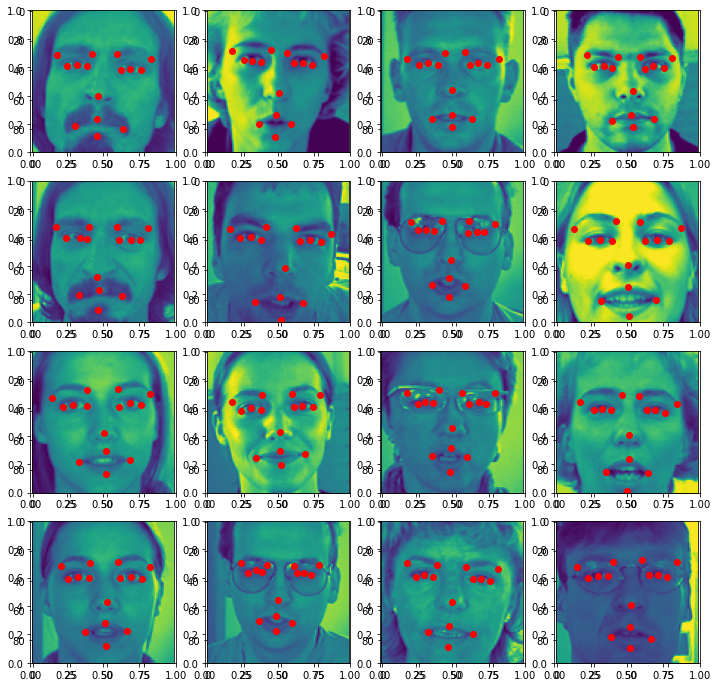

In [6]:
utils_cstm.vis_im_keypoint(train_imgs, training_keypoints )

## Image Augmentation
The next thing we have to do is add augmentation to our dataset. Adding various augmentations to our dataset allows the model to generalize better to a wide variety of images that it may not have enountered. Furthermore, augmentation increases our dataset so we will have more data to train.

We will add the following augmentations to our dataset:
- Horizontal Flip
- Linear Constrast
- Gaussian Blur
- Rotation
- Scaling

In [7]:
import augmentation_cstm

### Gaussian Blur & Linear Contrast
Code is in `augmentation_cstm.py`.

<class 'numpy.ndarray'> (4280, 96, 96, 1) (4280, 30)


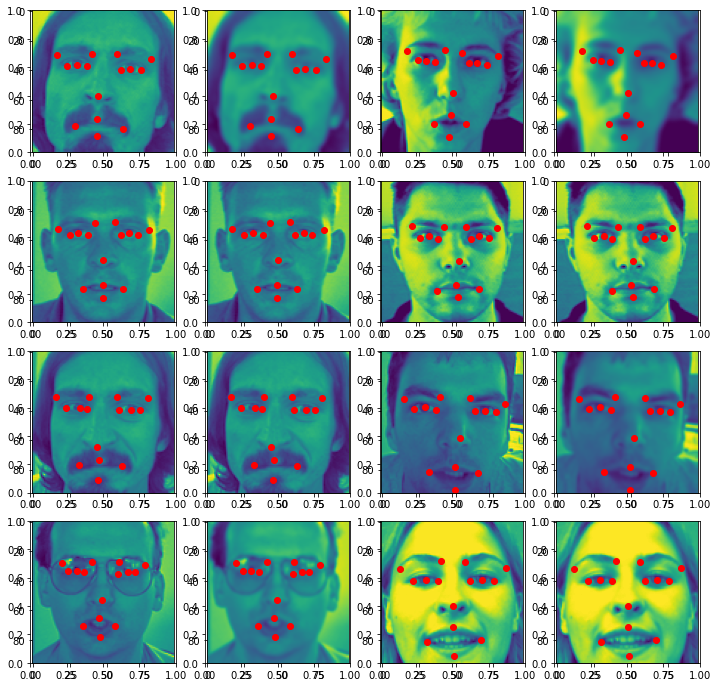

In [8]:
aug_imgs_train_v1, aug_points_train_v1 = augmentation_cstm.gnoise_lincontrast(train_imgs, training_keypoints)
print (type(aug_imgs_train_v1), aug_imgs_train_v1.shape, aug_points_train_v1.shape)
utils_cstm.vis_im_keypoint(aug_imgs_train_v1, aug_points_train_v1 )

### Rotation and Scaling
Code is in `augmentation_cstm.py`.

<class 'numpy.ndarray'> (8560, 96, 96, 1) (8560, 30)


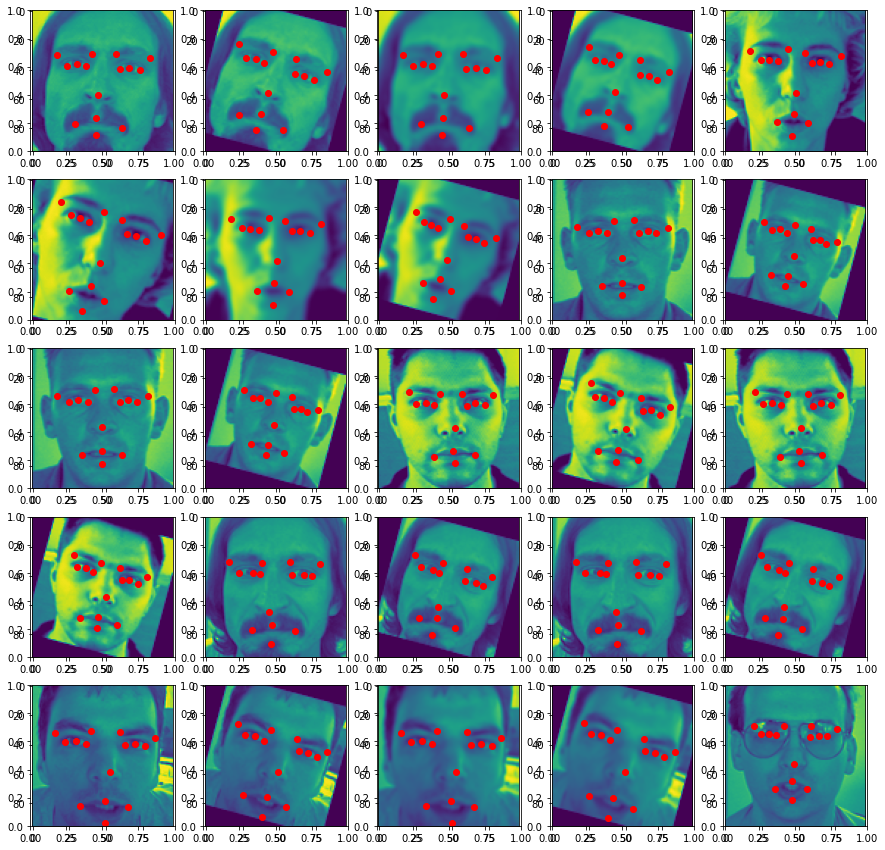

In [9]:
aug_imgs_train_v2, aug_points_train_v2 = augmentation_cstm.rotate_scale_aug(aug_imgs_train_v1, aug_points_train_v1)
print(type(aug_imgs_train_v2), aug_imgs_train_v2.shape, aug_points_train_v2.shape)
utils_cstm.vis_im_keypoint(aug_imgs_train_v2, aug_points_train_v2, num_imgs= 25 )

### Horizontal Flip

size of training data now:  (17120, 96, 96, 1) (17120, 30)


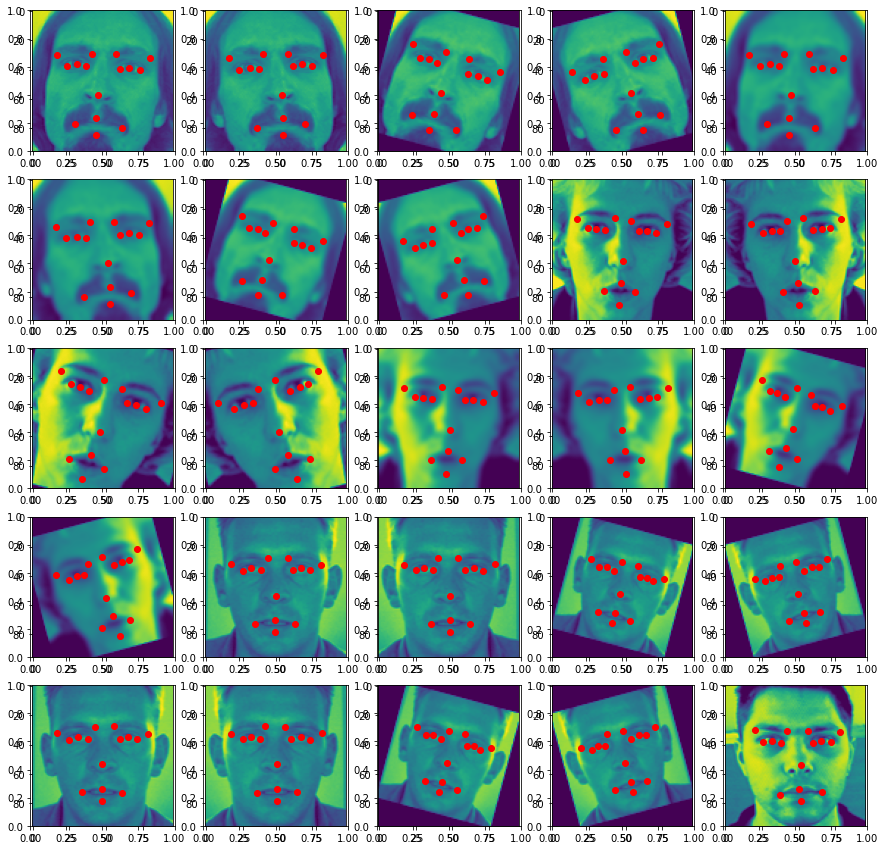

In [10]:
aug_imgs_train_v3, aug_points_train_v3 = augmentation_cstm.aug_flip(aug_imgs_train_v2, aug_points_train_v2)
print ('size of training data now: ', aug_imgs_train_v3.shape, aug_points_train_v3.shape)
utils_cstm.vis_im_keypoint(aug_imgs_train_v3, aug_points_train_v3, num_imgs= 25)

In [11]:
imgs_train_final = aug_imgs_train_v3
points_train_final = aug_points_train_v3

## View and Save Final Dataset
Now that we have prepared and augmented our dataset. Let's take a quick peek at it and save all the data so we can train our models using the same datasets in future notebooks.

In [12]:
from sklearn.model_selection import train_test_split

X_test = pd.read_csv(f'{BASE_DIR}/data/test.csv')
X_test = utils_cstm.prepare_raw_images(X_test)

X_train, X_val, y_train, y_val = train_test_split(imgs_train_final, points_train_final, test_size=0.10)

print(f'Train Images: {X_train.shape}')
print(f'Train Keypoints: {y_train.shape}\n')

print(f'Val Images: {X_val.shape}')
print(f'Val Keypoints: {y_val.shape}\n')

print(f'Test Images: {X_test.shape}\n')

Train Images: (15408, 96, 96, 1)
Train Keypoints: (15408, 30)

Val Images: (1712, 96, 96, 1)
Val Keypoints: (1712, 30)

Test Images: (1783, 96, 96, 1)



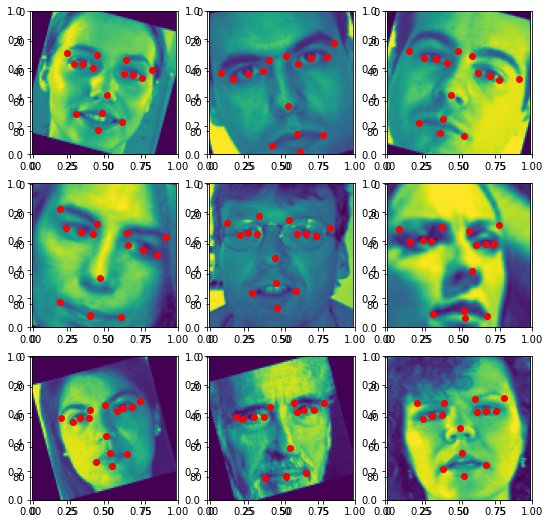

In [13]:
utils_cstm.vis_im_keypoint(X_train, y_train, num_imgs= 9)

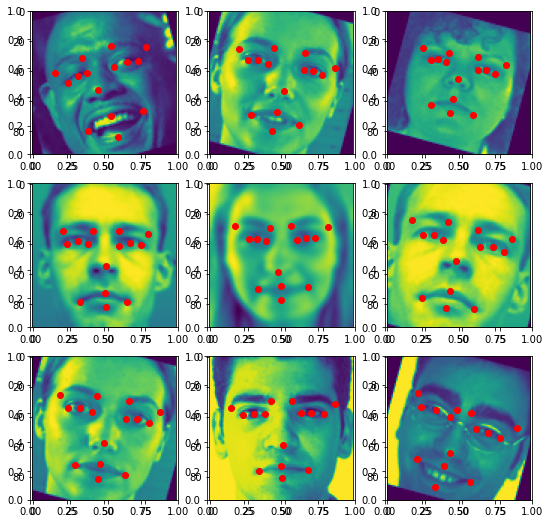

In [14]:
utils_cstm.vis_im_keypoint(X_val, y_val, num_imgs= 9)

In [15]:
np.save(f'{BASE_DIR}/data/train_X_dat', X_train)
np.save(f'{BASE_DIR}/data/train_Y_dat', y_train)
np.save(f'{BASE_DIR}/data/val_X_dat', X_val)
np.save(f'{BASE_DIR}/data/val_Y_dat', y_val)
np.save(f'{BASE_DIR}/data/test_X_dat', X_test)


# remove files if they already exist before unzipping
if os.path.exists(f'{BASE_DIR}/data/training.csv'):
    os.remove(f'{BASE_DIR}/data/training.csv')
if os.path.exists(f'{BASE_DIR}/data/test.csv'):
    os.remove(f'{BASE_DIR}/data/test.csv')
if os.path.exists(f'{BASE_DIR}/data/val.csv'):
    os.remove(f'{BASE_DIR}/data/val.csv')
    

We have now saved our full dataset and ready to train models on it! The other notebooks in this repository focus on training a specific model. 